In [21]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [22]:
# Read the data from a CSV file and select relevant columns
df_queries = pd.read_csv('antique_queries.csv')
df_queries = df_queries[['query_id','text']]

df_docs = pd.read_csv('antique_data.csv')
df_docs = df_docs[['doc_id','text']]

df_qrel = pd.read_csv('antique_qrels.csv')
df_qrel = df_qrel[['query_id','doc_id','relevence']]

In [23]:
df_docs.head(2)

,doc_id,text
0,2020338_0,A small group of politicians believed strongly...
1,2020338_1,Because there is a lot of oil in Iraq.


In [24]:
df_docs.rename(columns={'text':'doc_text'},
          inplace=True)

In [25]:
# Define a function to map relevance values to binary labels
def map_values(value):
    if value in [3, 4]:
        return 1
    else:
        return 0

In [26]:
df_qrel['label'] = df_qrel['relevence'].apply(map_values)

# Drop duplicate entries based on query_id and doc_id in the relevance data
df_qrel1 = df_qrel.drop_duplicates(subset=['query_id','doc_id'])
df_qrel1

,query_id,doc_id,relevence,label
0,1964316,1964316_5,4,1
1,1964316,1674088_11,1,0
2,1964316,1218838_13,2,0
3,1964316,1519022_15,2,0
4,1964316,3059341_5,2,0
...,...,...,...,...
6584,1262692,247023_6,3,1
6585,1262692,1499030_5,3,1
6586,1262692,2916758_0,3,1
6587,1262692,1105845_15,3,1


In [27]:
# Merge the query data and relevance data based on query_id
merged_df = df_queries.merge(df_qrel1, on='query_id', how='left')

# Drop duplicate entries based on query_id and doc_id in the merged data
merged_df = merged_df.drop_duplicates(subset=['query_id','doc_id'])
merged_df

,query_id,text,doc_id,relevence,label
0,3990512,how can we get concentration onsomething?,3990512_1,4,1
1,3990512,how can we get concentration onsomething?,2036065_1,2,0
2,3990512,how can we get concentration onsomething?,3265991_12,2,0
3,3990512,how can we get concentration onsomething?,3149758_0,1,0
4,3990512,how can we get concentration onsomething?,3990512_0,3,1
...,...,...,...,...,...
6584,1971899,what is masturbat***?,1971899_6,2,0
6585,1971899,what is masturbat***?,1971899_7,2,0
6586,1971899,what is masturbat***?,1971899_1,4,1
6587,1971899,what is masturbat***?,1971899_2,1,0


In [28]:
# Create a DataFrame for exploratory data analysis (EDA) with relevant columns
eda_df =  merged_df[['query_id','doc_id','label']]

# Print basic information about the EDA DataFrame
print("Basic Information:")
print(eda_df.info())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6589 entries, 0 to 6588
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   query_id  6589 non-null   int64 
 1   doc_id    6589 non-null   object
 2   label     6589 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 205.9+ KB
None


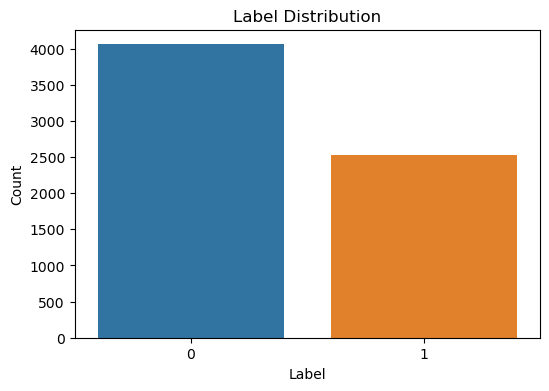

In [31]:
# Count the occurrences of each label and visualize the label distribution
label_counts = eda_df['label'].value_counts()

plt.figure(figsize=(6, 4))
sns.countplot(data=eda_df, x='label')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [30]:
# Calculate and display the number of unique query_ids and doc_ids
unique_query_ids = eda_df['query_id'].nunique()
unique_doc_ids = eda_df['doc_id'].nunique()
print(f"\nNumber of unique query_ids: {unique_query_ids}")
print(f"Number of unique doc_ids: {unique_doc_ids}")


Number of unique query_ids: 200
Number of unique doc_ids: 6486


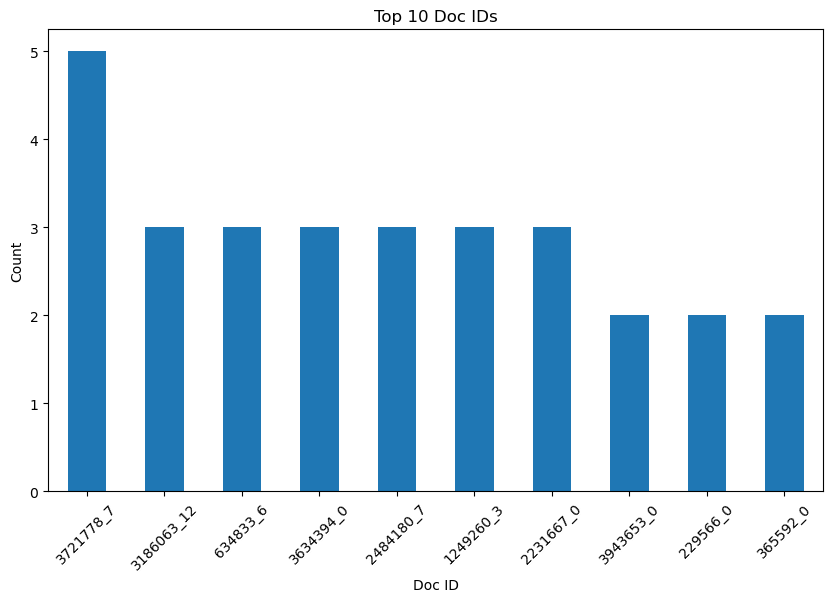

In [32]:
# Visualize the top 10 most common doc_ids
top_doc_ids = eda_df['doc_id'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_doc_ids.plot(kind='bar')
plt.title("Top 10 Doc IDs")
plt.xlabel("Doc ID")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [33]:
# Group data by query_id and calculate the count of documents per query
doc_count_per_query = eda_df.groupby('query_id')['doc_id'].count().reset_index(name='doc_count')

# Sort the results by document count in descending order
doc_count_per_query.sort_values(by='doc_count', ascending=[False])

,query_id,doc_count
173,4018891,84
194,4406669,68
191,4372730,64
79,1866981,64
41,922849,60
...,...,...
197,4467100,12
192,4377861,9
146,3382736,9
11,224109,4


In [34]:
# Group data by query_id and calculate various statistics
doc_count_per_query = eda_df.groupby('query_id').agg(doc_count=('doc_id', 'count'),
                                                      label_1_count=('label', 'sum'),
                                                      label_0_count=('label', lambda x: (x == 0).sum()),
                                                      ).reset_index()

# Sort the results by document count in descending order
sorted_doc_count_per_query = doc_count_per_query.sort_values(by='doc_count', ascending=False)

sorted_doc_count_per_query

,query_id,doc_count,label_1_count,label_0_count
173,4018891,84,35,49
194,4406669,68,41,27
191,4372730,64,28,36
79,1866981,64,19,45
41,922849,60,25,35
...,...,...,...,...
197,4467100,12,1,11
192,4377861,9,4,5
146,3382736,9,4,5
11,224109,4,1,3


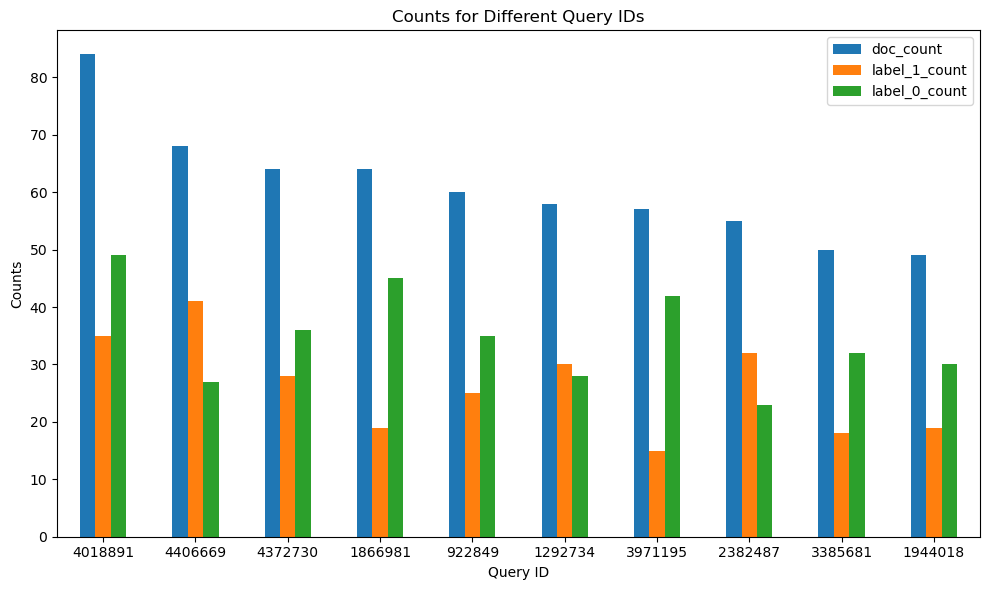

In [35]:
# Select the top 10 query_ids by document count
sorted_doc_count_per_query = sorted_doc_count_per_query.head(10)
sorted_doc_count_per_query.set_index('query_id', inplace=True)

# Visualize the document count and label statistics for the top 10 query_ids
ax = sorted_doc_count_per_query.plot(kind='bar', figsize=(10, 6))
ax.set_ylabel('Counts')
ax.set_xlabel('Query ID')
ax.set_title('Counts for Different Query IDs')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.tight_layout()

# Show the plot
plt.show()

In [36]:
# Merge the previously merged DataFrame with the document data based on doc_id
merged_df_docs = merged_df.merge(df_docs, on='doc_id', how='left')

In [37]:
merged_df_docs.head(5)

,query_id,text,doc_id,relevence,label,doc_text
0,3990512,how can we get concentration onsomething?,3990512_1,4,1,"For one thing, focus on what you want to achie..."
1,3990512,how can we get concentration onsomething?,2036065_1,2,0,just by concentration
2,3990512,how can we get concentration onsomething?,3265991_12,2,0,concentration
3,3990512,how can we get concentration onsomething?,3149758_0,1,0,Diffusion is when solutes go from a higher con...
4,3990512,how can we get concentration onsomething?,3990512_0,3,1,Try blocking the distractions as much as possi...


In [43]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FARMWISE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FARMWISE\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [39]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [47]:
#Function to perform Text Analysis

def perform_text_eda(dataframe, text_column, custom_stopwords=None):
    # Function to preprocess text
    def preprocess_text(text):
        # Remove punctuation and symbols using regular expressions
        cleaned_text = re.sub(r'[^\w\s]', '', text)
        return cleaned_text

    # Apply preprocessing to text column
    dataframe['cleaned_text'] = dataframe[text_column].apply(preprocess_text)

    # Calculate word and character counts
    dataframe['word_count'] = dataframe['cleaned_text'].apply(lambda x: len(word_tokenize(x)))
    dataframe['char_count'] = dataframe['cleaned_text'].apply(lambda x: len(x))

    # Calculate word frequency distribution
    words = word_tokenize(' '.join(dataframe['cleaned_text']))
    fdist = FreqDist(words)

    # Apply stopwords if provided
    if custom_stopwords:
        filtered_words = [[word for word in word_tokenize(text) if word.lower() not in custom_stopwords] for text in dataframe['cleaned_text']]
        fdist_filtered = FreqDist([word for sublist in filtered_words for word in sublist])
    else:
        filtered_words = words
        fdist_filtered = fdist


    percentile_values = np.percentile(dataframe['word_count'], percentiles)


    plt.plot(percentiles, percentile_values, marker='o')
    plt.title('Percentile Line Chart')
    plt.xlabel('Percentile')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()





        word_count   char_count
count  6589.000000  6589.000000
mean     45.589164   247.380483
std      56.968753   323.042317
min       1.000000     3.000000
25%      15.000000    78.000000
50%      31.000000   164.000000
75%      56.000000   302.000000
max     719.000000  3898.000000
Top 10 most common words:
[('the', 13013), ('to', 8052), ('and', 7304), ('a', 7062), ('of', 6232), ('is', 5524), ('you', 4695), ('in', 4138), ('it', 3837), ('that', 3525)]
Top 10 most common non-stopwords:
[('people', 1144), ('dont', 1057), ('like', 999), ('get', 981), ('would', 732), ('one', 723), ('know', 714), ('think', 699), ('make', 559), ('go', 536)]


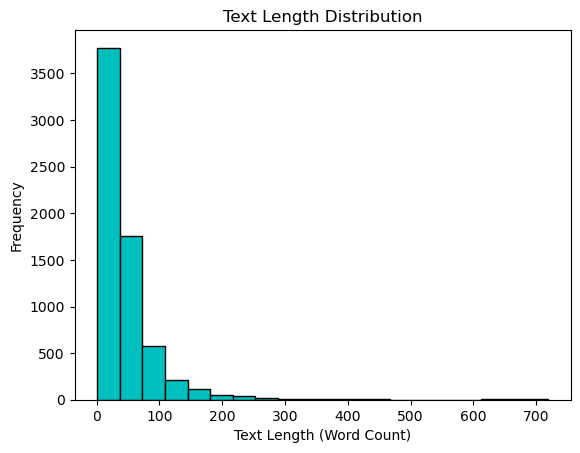

TF-IDF Matrix shape: (6589, 22006)


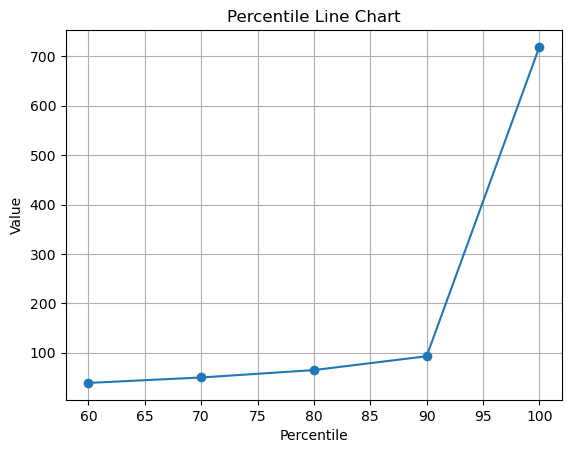

In [48]:

custom_stopwords = stop_words

# Call the function
perform_text_eda(merged_df_docs, 'doc_text', custom_stopwords)
